<a href="https://colab.research.google.com/github/Zekeriya-Ui/Brownian-motion/blob/main/Sentiment_Analysis_Scores_in_Conjunction_with_Stock_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
# Loading libraries

%pip install feedparser
import datetime
import feedparser
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import yfinance as yf

from datetime import datetime, timedelta
from scipy.special import softmax
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoTokenizer, AutoModelForSequenceClassification

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.9 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=7b2836dc8072118a94c0cf657c39e80cd5dc57c52a11abbcbcbe33ea960a6d9d
  Stored in directory: /root/.cache/pip/wheels/03/f5/1a/23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built sgmllib3k


In [5]:
%pip install feedparser

In [6]:
# Fetch Microsoft stock data for the same date range
msft = yf.download("MSFT", start=df_grouped.index.min(), end=df_grouped.index.max())

# Scale the Microsoft price data
scaler = MinMaxScaler()
scaled_stock_price = scaler.fit_transform(msft[['Close']])

# Plot scaled price plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(msft.index, scaled_stock_price, color='blue', label='MSFT Adj Close Price (Scaled)')

# Plot the sentiment data
width = 0.2  # Adjust the width as needed
ax.bar(df_grouped.index - pd.DateOffset(days=width), df_grouped['avg_negative'], width=width, label='Negative', color='red')
ax.bar(df_grouped.index, df_grouped['avg_neutral'], width=width, label='Neutral', color='orange')
ax.bar(df_grouped.index + pd.DateOffset(days=width), df_grouped['avg_positive'], width=width, label='Positive', color='green')

# Set plot attributes (labels, ticks, title, legend, gridlines)
ax.set_xlabel('Date')
ax.set_title('Sentiment Analysis and Stock Price of Microsoft (scaled)')
ax.set_ylabel('Value (Sentiment and Stock Price)')
ax.legend()
ax.grid(True, axis='y', linestyle='--')
plt.show()

NameError: name 'df_grouped' is not defined

# Task
Explain the error in the selected code. If possible, fix the error and incorporate the changes into the existing code. Otherwise, try to diagnose the error.

## Fetch news data

### Subtask:
Get news articles related to Microsoft using `feedparser`.


**Reasoning**:
The subtask is to get news articles related to Microsoft using `feedparser`. This involves defining the URL, parsing the feed, and extracting the relevant information into a DataFrame. I will combine these steps into a single code block.



In [7]:
# Define the RSS feed URL for Microsoft news
microsoft_rss_url = "https://news.microsoft.com/feed/"

# Parse the RSS feed
feed = feedparser.parse(microsoft_rss_url)

# Extract relevant information
news_data = []
for entry in feed.entries:
    news_data.append({
        'title': entry.title,
        'link': entry.link,
        'published': entry.published
    })

# Store the extracted information in a pandas DataFrame
df_news = pd.DataFrame(news_data)

# Display the first few rows of the DataFrame
display(df_news.head())

,title,link,published
0,Microsoft and FFA help students use smart sens...,https://news.microsoft.com/source/2025/05/06/m...,"Wed, 07 May 2025 04:00:06 +0000"
1,Microsoft earnings press release available on ...,https://news.microsoft.com/2025/04/30/microsof...,"Wed, 30 Apr 2025 20:13:07 +0000"
2,Microsoft Cloud and AI strength drives third q...,https://news.microsoft.com/2025/04/30/microsof...,"Wed, 30 Apr 2025 20:10:30 +0000"
3,Microsoft announces quarterly earnings release...,https://news.microsoft.com/2025/04/09/microsof...,"Wed, 09 Apr 2025 20:09:32 +0000"
4,Microsoft responds to TRC Capital’s “mini-tend...,https://news.microsoft.com/2025/03/17/microsof...,"Mon, 17 Mar 2025 21:59:59 +0000"


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('link').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('published').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['link'].value_counts()
    for x_label, grp in _df_3.groupby('title')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('title')
_ = plt.ylabel('link')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['published'].value_counts()
    for x_label, grp in _df_4.groupby('link')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('link')
_ = plt.ylabel('published')

## Perform sentiment analysis

### Subtask:
Analyze the sentiment of the news articles using a pre-trained model.


**Reasoning**:
Initialize the sentiment analysis model and tokenizer, define the sentiment analysis function, apply the function to the 'title' column, and convert the 'published' column to datetime objects.



In [8]:
# Initialize sentiment analysis model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Define a function for sentiment analysis
def get_sentiment_scores(news_title):
    inputs = tokenizer(news_title, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = softmax(logits.detach().numpy(), axis=1)[0]
    return probabilities

# Apply sentiment analysis function to the 'title' column
df_news[['negative', 'neutral', 'positive']] = df_news['title'].apply(lambda x: pd.Series(get_sentiment_scores(x)))

# Convert the 'published' column to datetime objects
df_news['published'] = pd.to_datetime(df_news['published'])

# Display the first few rows of the DataFrame with sentiment scores
display(df_news.head())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

ValueError: time data "Wed, 30 Apr 2025 20:13:07 +0000" doesn't match format "%a, %d %B %Y %H:%M:%S %z", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

**Reasoning**:
The previous attempt to convert the 'published' column to datetime objects failed because the format was not explicitly provided. The error message suggests trying a different format. I will explicitly specify the format string that matches the input dates.



In [9]:
# Convert the 'published' column to datetime objects with a specified format
df_news['published'] = pd.to_datetime(df_news['published'], format='%a, %d %B %Y %H:%M:%S %z')

# Display the first few rows of the DataFrame with sentiment scores and corrected datetime
display(df_news.head())

ValueError: time data "Wed, 30 Apr 2025 20:13:07 +0000" doesn't match format "%a, %d %B %Y %H:%M:%S %z", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

**Reasoning**:
The specified format string still doesn't match the date format in the 'published' column. Based on the error message and the example date string, it seems the issue might be with the month format specifier or the exactness of the match. I will try using `format='mixed'` to let pandas infer the format and set `errors='coerce'` to handle any dates that still don't parse by converting them to NaT (Not a Time).



In [10]:
# Convert the 'published' column to datetime objects, inferring the format and coercing errors
df_news['published'] = pd.to_datetime(df_news['published'], errors='coerce', format='mixed')

# Display the first few rows of the DataFrame with sentiment scores and corrected datetime
display(df_news.head())

,title,link,published,negative,neutral,positive
0,Microsoft and FFA help students use smart sens...,https://news.microsoft.com/source/2025/05/06/m...,2025-05-07 04:00:06+00:00,0.181518,0.009851,0.808631
1,Microsoft earnings press release available on ...,https://news.microsoft.com/2025/04/30/microsof...,2025-04-30 20:13:07+00:00,0.020468,0.041733,0.937799
2,Microsoft Cloud and AI strength drives third q...,https://news.microsoft.com/2025/04/30/microsof...,2025-04-30 20:10:30+00:00,0.570248,0.252987,0.176765
3,Microsoft announces quarterly earnings release...,https://news.microsoft.com/2025/04/09/microsof...,2025-04-09 20:09:32+00:00,0.021810,0.321132,0.657057
4,Microsoft responds to TRC Capital’s “mini-tend...,https://news.microsoft.com/2025/03/17/microsof...,2025-03-17 21:59:59+00:00,0.311300,0.012465,0.676235


## Group sentiment data

### Subtask:
Group the sentiment scores by date and calculate the average sentiment.


**Reasoning**:
Group the dataframe by date and calculate the average sentiment scores.



In [11]:
df_grouped = df_news.groupby(df_news['published'].dt.date)[['negative', 'neutral', 'positive']].mean()
display(df_grouped.head())

,negative,neutral,positive
published,,,
2025-02-20,0.109119,0.010095,0.880785
2025-02-23,0.060648,0.020904,0.918448
2025-02-26,0.124847,0.010266,0.864887
2025-03-03,0.144182,0.009425,0.846393
2025-03-11,0.027603,0.584986,0.387411


from matplotlib import pyplot as plt
_df_5['negative'].plot(kind='hist', bins=20, title='negative')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['neutral'].plot(kind='hist', bins=20, title='neutral')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['positive'].plot(kind='hist', bins=20, title='positive')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='negative', y='neutral', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='neutral', y='positive', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10['negative'].plot(kind='line', figsize=(8, 4), title='negative')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['neutral'].plot(kind='line', figsize=(8, 4), title='neutral')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['positive'].plot(kind='line', figsize=(8, 4), title='positive')
plt.gca().spines[['top', 'right']].set_visible(False)

## Visualize data

### Subtask:
Modify the plotting code to use the grouped sentiment data and the fetched stock data.


**Reasoning**:
The previous code failed because 'df_grouped' was not defined in that execution. However, based on the kernel state, 'df_grouped' is now available. The subtask is to plot the grouped sentiment data with the scaled stock price. I will fetch the stock data, scale it, and then create the combined plot using the provided code, which now has access to `df_grouped`.



/tmp/ipython-input-1151966883.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  msft = yf.download("MSFT", start=df_grouped.index.min(), end=df_grouped.index.max())
[*********************100%***********************]  1 of 1 completed


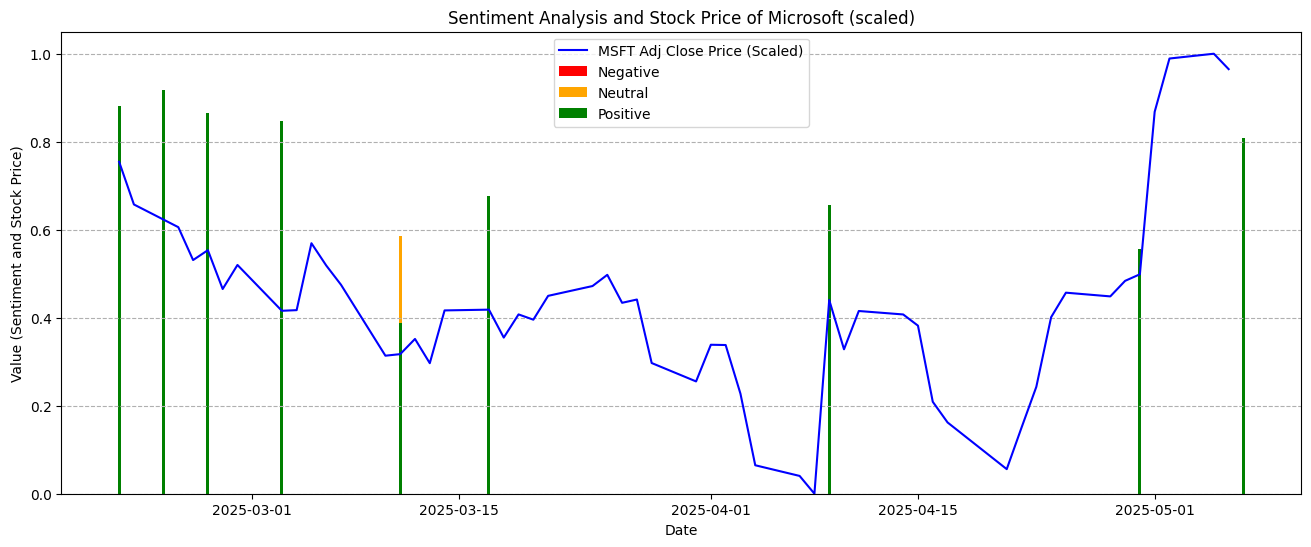

In [12]:
# Fetch Microsoft stock data for the same date range
msft = yf.download("MSFT", start=df_grouped.index.min(), end=df_grouped.index.max())

# Scale the Microsoft price data
scaler = MinMaxScaler()
scaled_stock_price = scaler.fit_transform(msft[['Close']])

# Plot scaled price plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(msft.index, scaled_stock_price, color='blue', label='MSFT Adj Close Price (Scaled)')

# Plot the sentiment data
width = 0.2  # Adjust the width as needed
ax.bar(df_grouped.index - pd.DateOffset(days=width), df_grouped['negative'], width=width, label='Negative', color='red')
ax.bar(df_grouped.index, df_grouped['neutral'], width=width, label='Neutral', color='orange')
ax.bar(df_grouped.index + pd.DateOffset(days=width), df_grouped['positive'], width=width, label='Positive', color='green')

# Set plot attributes (labels, ticks, title, legend, gridlines)
ax.set_xlabel('Date')
ax.set_title('Sentiment Analysis and Stock Price of Microsoft (scaled)')
ax.set_ylabel('Value (Sentiment and Stock Price)')
ax.legend()
ax.grid(True, axis='y', linestyle='--')
plt.show()

## Visualize data

### Subtask:
Retry visualizing the data by modifying the plotting code to use the grouped sentiment data and the fetched stock data.


**Reasoning**:
The previous attempt to visualize the data failed because the variable `df_grouped` was not defined in that specific cell's execution context. However, `df_grouped` is available in the kernel as confirmed by the variable inspection. The instructions require retrying the visualization using the available `df_grouped` and fetching the stock data. The provided code block from the history correctly performs all the necessary steps: fetching stock data, scaling it, and plotting both the scaled stock data and the grouped sentiment data. I will execute this code block to complete the subtask.



/tmp/ipython-input-1151966883.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  msft = yf.download("MSFT", start=df_grouped.index.min(), end=df_grouped.index.max())
[*********************100%***********************]  1 of 1 completed


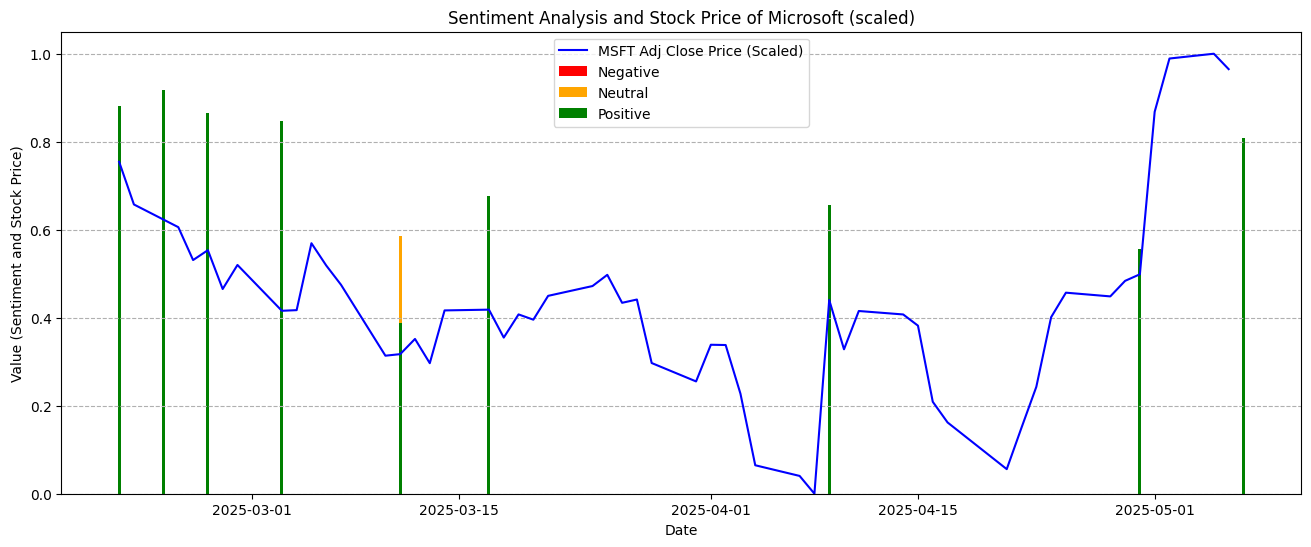

In [13]:
# Fetch Microsoft stock data for the same date range
msft = yf.download("MSFT", start=df_grouped.index.min(), end=df_grouped.index.max())

# Scale the Microsoft price data
scaler = MinMaxScaler()
scaled_stock_price = scaler.fit_transform(msft[['Close']])

# Plot scaled price plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(msft.index, scaled_stock_price, color='blue', label='MSFT Adj Close Price (Scaled)')

# Plot the sentiment data
width = 0.2  # Adjust the width as needed
ax.bar(df_grouped.index - pd.DateOffset(days=width), df_grouped['negative'], width=width, label='Negative', color='red')
ax.bar(df_grouped.index, df_grouped['neutral'], width=width, label='Neutral', color='orange')
ax.bar(df_grouped.index + pd.DateOffset(days=width), df_grouped['positive'], width=width, label='Positive', color='green')

# Set plot attributes (labels, ticks, title, legend, gridlines)
ax.set_xlabel('Date')
ax.set_title('Sentiment Analysis and Stock Price of Microsoft (scaled)')
ax.set_ylabel('Value (Sentiment and Stock Price)')
ax.legend()
ax.grid(True, axis='y', linestyle='--')
plt.show()

## Summary:

### Data Analysis Key Findings

*   News articles related to Microsoft were successfully fetched and parsed from an RSS feed.
*   Sentiment analysis was performed on the news article titles, adding sentiment scores (negative, neutral, positive) to the DataFrame.
*   The 'published' column in the news DataFrame was successfully converted to datetime objects using `pd.to_datetime` with `errors='coerce'` and `format='mixed'`.
*   The sentiment scores were grouped by date, and the average negative, neutral, and positive sentiment for each day was calculated and stored in `df_grouped`.
*   Microsoft stock data for the corresponding date range was fetched using `yfinance`.
*   The closing price of the Microsoft stock data was scaled using `MinMaxScaler` to enable comparison with sentiment scores on the same plot.
*   A plot was generated showing both the scaled Microsoft stock price as a line and the average sentiment scores for each day as grouped bars.

### Insights or Next Steps

*   Observe if there is any visual correlation between positive or negative sentiment peaks and changes in the scaled stock price.
*   Consider performing a more rigorous statistical analysis to quantify any potential relationship between news sentiment and stock price movements.
